In [1]:
import numpy as np
import pandas as pd
import os
print(os.listdir("../predict_future_sales/input/"))
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance

['sales_train.csv', 'Untitled.ipynb', 'shops.csv', 'test.csv', 'item_categories.csv', 'items.csv', 'sample_submission.csv']


In [2]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

In [3]:
pd.get_option("display.max_columns")

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 120)
#現在の最大表示行数の出力
pd.get_option("display.max_rows")

#最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 120)

In [4]:
DATA_FOLDER = '../predict_future_sales/input'

transactions = pd.read_csv('input/sales_train.csv')
items = pd.read_csv('input/items.csv')
item_categories = pd.read_csv('input/item_categories.csv')
shops = pd.read_csv(os.path.join(DATA_FOLDER,'shops.csv'))
test = pd.read_csv(os.path.join(DATA_FOLDER,'test.csv'))

In [5]:
transactions.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


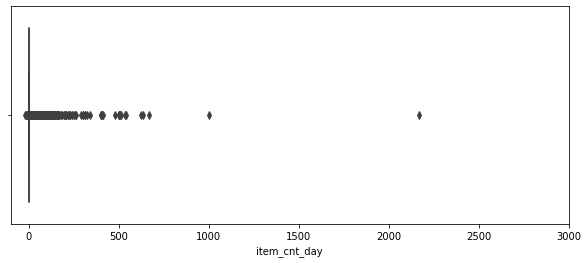

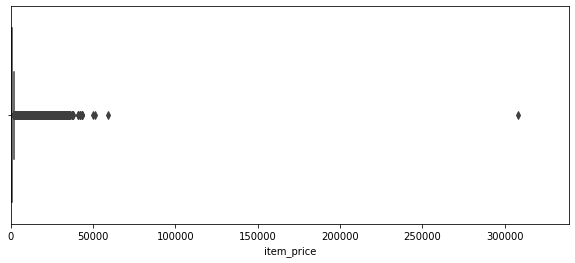

In [6]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=transactions.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(transactions.item_price.min(), transactions.item_price.max()*1.1)
sns.boxplot(x=transactions.item_price)

In [7]:
transactions = transactions[transactions.item_cnt_day < 1001]
transactions  = transactions[transactions.item_price < 100000]

In [8]:
items.head(5)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [9]:
item_categories.head(5)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [10]:
shops.head(10)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [11]:
shops['city_name'] = shops['shop_name'].map(lambda x:x.split(' ')[0])
shops['city_name'].value_counts()

Москва              13
Тюмень               3
Воронеж              3
РостовНаДону         3
!Якутск              2
Казань               2
Красноярск           2
Новосибирск          2
Самара               2
Н.Новгород           2
Якутск               2
Уфа                  2
СПб                  2
Жуковский            2
Химки                1
Волжский             1
Калуга               1
Ярославль            1
Томск                1
Омск                 1
Курск                1
Адыгея               1
Балашиха             1
Цифровой             1
Вологда              1
Выездная             1
Сургут               1
Сергиев              1
Интернет-магазин     1
Коломна              1
Чехов                1
Мытищи               1
Name: city_name, dtype: int64

In [12]:
shops.loc[shops['city_name'] == '!Якутск', 'city_name'] = 'Якутск'
shops.city_name.value_counts()

Москва              13
Якутск               4
Тюмень               3
Воронеж              3
РостовНаДону         3
Уфа                  2
Казань               2
Красноярск           2
Новосибирск          2
Самара               2
Н.Новгород           2
СПб                  2
Жуковский            2
Цифровой             1
Адыгея               1
Калуга               1
Ярославль            1
Томск                1
Омск                 1
Курск                1
Балашиха             1
Волжский             1
Химки                1
Выездная             1
Вологда              1
Сергиев              1
Интернет-магазин     1
Мытищи               1
Коломна              1
Сургут               1
Чехов                1
Name: city_name, dtype: int64

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [14]:
item_categories['split'] = item_categories['item_category_name'].str.split(' - ')
item_categories['type'] = item_categories['split'].map(lambda x:x[0].strip())
item_categories['subtype'] = item_categories['split'].map(lambda x:x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['type'] = le.fit_transform(item_categories['type'])
item_categories['subtype'] = le.fit_transform(item_categories['subtype'])

In [15]:
encoding = shops.groupby('city_name').size()
encoding = encoding / len(shops)
shops['city_frequency'] = shops.city_name.map(encoding)
shops.city_frequency.describe()

# encoding = test.groupby('item_id').size()
# encoding = encoding/len(test)
# test['item_freq'] = test.item_id.map(encoding)

# encoding = transactions.groupby('item_id').size()
# encoding = encoding/len(transactions)
# transactions['item_freq'] = transactions.item_id.map(encoding)

count    60.000000
mean      0.072778
std       0.077628
min       0.016667
25%       0.016667
50%       0.033333
75%       0.066667
max       0.216667
Name: city_frequency, dtype: float64

In [16]:
transactions = pd.merge(transactions, items, on='item_id', how='left')
transactions = transactions.drop('item_name',axis=1)
transactions.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


In [17]:
transactions = pd.merge(transactions, shops, on='shop_id', how='left')
transactions.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,shop_name,city_name,city_frequency
0,02.01.2013,0,59,22154,999.00,1.0,37,"Ярославль ТЦ ""Альтаир""",Ярославль,0.016667
1,03.01.2013,0,25,2552,899.00,1.0,58,"Москва ТРК ""Атриум""",Москва,0.216667
2,05.01.2013,0,25,2552,899.00,-1.0,58,"Москва ТРК ""Атриум""",Москва,0.216667
3,06.01.2013,0,25,2554,1709.05,1.0,58,"Москва ТРК ""Атриум""",Москва,0.216667
4,15.01.2013,0,25,2555,1099.00,1.0,56,"Москва ТРК ""Атриум""",Москва,0.216667


In [18]:
from itertools import product
index_col = ['shop_id','item_id','date_block_num']

In [19]:
grid = []
for block_num in transactions['date_block_num'].unique():
    cur_shops = transactions.loc[transactions['date_block_num'] == block_num, 'shop_id'].unique()
    #This shows all shops in three countries working in each month
    cur_items = transactions.loc[transactions['date_block_num']==block_num,'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops,cur_items,[block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid),columns=index_col,dtype=np.int32)
grid.head(15)

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0
5,59,2565,0
6,59,2572,0
7,59,2573,0
8,59,2574,0
9,59,2593,0


## Make statistical features

In [20]:
mean_transactions = transactions.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'sum','item_price':np.mean}).reset_index()

mean_transactions.head(5)

,date_block_num,shop_id,item_id,item_cnt_day,item_price
0,0,0,32,6.0,221.0
1,0,0,33,3.0,347.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,128.5


In [21]:
mean_transactions.columns = ['date_block_num','shop_id','item_id','item_cnt_month','item_price']

In [22]:
mean_transactions.item_cnt_month.describe()

count    1.609123e+06
mean     2.265853e+00
std      8.466196e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.644000e+03
Name: item_cnt_month, dtype: float64

In [23]:
mean_transactions.item_cnt_month = mean_transactions.item_cnt_month.clip(0,20)
mean_transactions.item_cnt_month.describe()

count    1.609123e+06
mean     2.022807e+00
std      2.577964e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.000000e+01
Name: item_cnt_month, dtype: float64

In [24]:
mean_transactions = pd.merge(grid, mean_transactions, on=['date_block_num','shop_id','item_id'],how='left').fillna(0)
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price
0,59,22154,0,1.0,999.0
1,59,2552,0,0.0,0.0
2,59,2554,0,0.0,0.0
3,59,2555,0,0.0,0.0
4,59,2564,0,0.0,0.0
5,59,2565,0,0.0,0.0
6,59,2572,0,0.0,0.0
7,59,2573,0,0.0,0.0
8,59,2574,0,2.0,399.0
9,59,2593,0,0.0,0.0


In [25]:
mean_transactions = pd.merge(mean_transactions, items, on='item_id',how='left')
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59
5,59,2565,0,0.0,0.0,DEEP PURPLE Stormbringer (фирм.),56
6,59,2572,0,0.0,0.0,DEFTONES Koi No Yokan,55
7,59,2573,0,0.0,0.0,DEL REY LANA Born To Die,55
8,59,2574,0,2.0,399.0,DEL REY LANA Born To Die The Paradise Editio...,55
9,59,2593,0,0.0,0.0,DEPECHE MODE Music For The Masses,55


In [26]:
transactions['sales'] = transactions['item_cnt_day'] * transactions['item_price']

## I will make the similar dataframe about statistical features, but this time, these are lag features

In [27]:
item_mean =transactions.groupby(['item_id','date_block_num']).mean().reset_index()\
                        [['item_id','item_price','item_cnt_day','date_block_num','sales']]
item_mean.columns = ['item_id','item_price_per_item','item_cnt_day_per_item','date_block_num','sales_per_item']



item_std =transactions.groupby(['item_id','date_block_num']).std().reset_index()\
                        [['item_id','item_price','item_cnt_day','date_block_num','sales']]
item_std.columns = ['item_id','price_std_per_item','cnt_day_std_per_item','date_block_num','sales_std_per_item']

In [28]:
mean_transactions = pd.merge(mean_transactions, item_mean, on=['date_block_num','item_id'],how='left')
mean_transactions = pd.merge(mean_transactions, item_std, on=['date_block_num','item_id'],how='left')
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,item_price_per_item,item_cnt_day_per_item,sales_per_item,price_std_per_item,cnt_day_std_per_item,sales_std_per_item
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.000000,1.000000,999.000000,0.000000,0.000000,0.000000
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.000000,0.000000,0.000000,0.000000,1.414214,1271.377993
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.050000,1.000000,1709.050000,NaN,NaN,NaN
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.850000,1.000000,1098.850000,0.212132,0.000000,0.212132
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.600000,1.000000,327.600000,47.851855,0.000000,47.851855
5,59,2565,0,0.0,0.0,DEEP PURPLE Stormbringer (фирм.),56,549.000000,1.000000,549.000000,0.000000,0.000000,0.000000
6,59,2572,0,0.0,0.0,DEFTONES Koi No Yokan,55,284.333333,1.000000,284.333333,36.275044,0.000000,36.275044
7,59,2573,0,0.0,0.0,DEL REY LANA Born To Die,55,299.000000,1.142857,341.714286,0.000000,0.534522,159.822223
8,59,2574,0,2.0,399.0,DEL REY LANA Born To Die The Paradise Editio...,55,392.986538,1.144231,450.534615,25.217555,0.379531,155.777822
9,59,2593,0,0.0,0.0,DEPECHE MODE Music For The Masses,55,254.200000,1.000000,254.200000,55.454486,0.000000,55.454486


In [29]:
mean_transactions['product_sales'] = mean_transactions['item_cnt_month'] * mean_transactions['item_price']

In [30]:
del item_mean

In [31]:
shop_mean_df = transactions.groupby(['date_block_num','shop_id']).mean().reset_index()\
                                 [['shop_id','date_block_num','item_cnt_day','item_price','sales']]
shop_mean_df.columns = ['shop_id','date_block_num','item_cnt_day_per_shop','item_price_per_shop','sales_per_shop']
mean_transactions = pd.merge(mean_transactions,shop_mean_df, on=['date_block_num','shop_id'],how='left')

shop_std_df =  transactions.groupby(['date_block_num','shop_id']).std().reset_index()\
                                 [['shop_id','date_block_num','item_cnt_day','item_price','sales']]
shop_std_df.columns = ['shop_id','date_block_num','cnt_day_std_shop','price_std_per_shop','sales_std_per_shop']
mean_transactions = pd.merge(mean_transactions,shop_std_df, on=['date_block_num','shop_id'],how='left')

In [32]:
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,item_price_per_item,item_cnt_day_per_item,sales_per_item,price_std_per_item,cnt_day_std_per_item,sales_std_per_item,product_sales,item_cnt_day_per_shop,item_price_per_shop,sales_per_shop,cnt_day_std_shop,price_std_per_shop,sales_std_per_shop
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.000000,1.000000,999.000000,0.000000,0.000000,0.000000,999.0,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.000000,0.000000,0.000000,0.000000,1.414214,1271.377993,0.0,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.050000,1.000000,1709.050000,NaN,NaN,NaN,0.0,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.850000,1.000000,1098.850000,0.212132,0.000000,0.212132,0.0,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.600000,1.000000,327.600000,47.851855,0.000000,47.851855,0.0,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
5,59,2565,0,0.0,0.0,DEEP PURPLE Stormbringer (фирм.),56,549.000000,1.000000,549.000000,0.000000,0.000000,0.000000,0.0,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
6,59,2572,0,0.0,0.0,DEFTONES Koi No Yokan,55,284.333333,1.000000,284.333333,36.275044,0.000000,36.275044,0.0,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
7,59,2573,0,0.0,0.0,DEL REY LANA Born To Die,55,299.000000,1.142857,341.714286,0.000000,0.534522,159.822223,0.0,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
8,59,2574,0,2.0,399.0,DEL REY LANA Born To Die The Paradise Editio...,55,392.986538,1.144231,450.534615,25.217555,0.379531,155.777822,798.0,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779
9,59,2593,0,0.0,0.0,DEPECHE MODE Music For The Masses,55,254.200000,1.000000,254.200000,55.454486,0.000000,55.454486,0.0,1.092041,820.174553,884.369789,0.4467,1626.46851,1781.954779


In [33]:
category_mean_df = transactions.groupby(['date_block_num','item_category_id']).mean().reset_index()[['item_category_id','date_block_num','item_cnt_day','item_price','sales']]
category_mean_df.columns = ['item_category_id','date_block_num','item_cnt_day_per_category','item_price_per_category','sales_per_category']
mean_transactions = pd.merge(mean_transactions, category_mean_df, on=['date_block_num','item_category_id'],how='left')

category_mean_df = transactions.groupby(['date_block_num','item_category_id']).std().reset_index()[['item_category_id','date_block_num','item_cnt_day','item_price','sales']]
category_mean_df.columns = ['item_category_id','date_block_num','cnt_day_std_per_category','price_std_per_category','sales_std_per_category']
mean_transactions = pd.merge(mean_transactions, category_mean_df, on=['date_block_num','item_category_id'],how='left')

In [34]:
shop_cat_df = transactions.groupby(['date_block_num', 'item_category_id', 'shop_id']).mean().reset_index()\
                          [['date_block_num', 'item_category_id', 'shop_id','item_cnt_day','item_price']]
shop_cat_df.columns = ['date_block_num','item_category_id','shop_id','cnt_day_shop_cat','price_shop_cat']
mean_transactions = pd.merge(mean_transactions, shop_cat_df, on=['date_block_num', 'item_category_id','shop_id'], how='left')

In [35]:
import gc 

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [36]:
mean_transactions = downcast_dtypes(mean_transactions)
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,item_price_per_item,item_cnt_day_per_item,sales_per_item,price_std_per_item,cnt_day_std_per_item,sales_std_per_item,product_sales,item_cnt_day_per_shop,item_price_per_shop,sales_per_shop,cnt_day_std_shop,price_std_per_shop,sales_std_per_shop,item_cnt_day_per_category,item_price_per_category,sales_per_category,cnt_day_std_per_category,price_std_per_category,sales_std_per_category,cnt_day_shop_cat,price_shop_cat
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.000000,1.000000,999.000000,0.000000,0.000000,0.000000,999.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.053414,465.036011,491.797668,0.385709,334.376770,398.859619,1.016949,451.226776
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.000000,0.000000,0.000000,0.000000,1.414214,1271.378052,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,0.969595,1401.858154,1371.483154,0.265064,545.689636,641.605957,NaN,NaN
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.050049,1.000000,1709.050049,NaN,NaN,NaN,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,0.969595,1401.858154,1371.483154,0.265064,545.689636,641.605957,NaN,NaN
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.849976,1.000000,1098.849976,0.212132,0.000000,0.212132,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.007519,867.447021,876.650024,0.086547,335.257874,361.018921,1.000000,1299.000000
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.600006,1.000000,327.600006,47.851856,0.000000,47.851856,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,0.990113,443.330017,433.212769,0.202288,465.695496,484.760101,1.000000,1274.000000
5,59,2565,0,0.0,0.0,DEEP PURPLE Stormbringer (фирм.),56,549.000000,1.000000,549.000000,0.000000,0.000000,0.000000,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.007519,867.447021,876.650024,0.086547,335.257874,361.018921,1.000000,1299.000000
6,59,2572,0,0.0,0.0,DEFTONES Koi No Yokan,55,284.333344,1.000000,284.333344,36.275043,0.000000,36.275043,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130
7,59,2573,0,0.0,0.0,DEL REY LANA Born To Die,55,299.000000,1.142857,341.714294,0.000000,0.534522,159.822220,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130
8,59,2574,0,2.0,399.0,DEL REY LANA Born To Die The Paradise Editio...,55,392.986542,1.144231,450.534607,25.217554,0.379531,155.777817,798.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130
9,59,2593,0,0.0,0.0,DEPECHE MODE Music For The Masses,55,254.199997,1.000000,254.199997,55.454487,0.000000,55.454487,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130


In [37]:
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,item_price_per_item,item_cnt_day_per_item,sales_per_item,price_std_per_item,cnt_day_std_per_item,sales_std_per_item,product_sales,item_cnt_day_per_shop,item_price_per_shop,sales_per_shop,cnt_day_std_shop,price_std_per_shop,sales_std_per_shop,item_cnt_day_per_category,item_price_per_category,sales_per_category,cnt_day_std_per_category,price_std_per_category,sales_std_per_category,cnt_day_shop_cat,price_shop_cat
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.000000,1.000000,999.000000,0.000000,0.000000,0.000000,999.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.053414,465.036011,491.797668,0.385709,334.376770,398.859619,1.016949,451.226776
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.000000,0.000000,0.000000,0.000000,1.414214,1271.378052,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,0.969595,1401.858154,1371.483154,0.265064,545.689636,641.605957,NaN,NaN
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.050049,1.000000,1709.050049,NaN,NaN,NaN,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,0.969595,1401.858154,1371.483154,0.265064,545.689636,641.605957,NaN,NaN
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.849976,1.000000,1098.849976,0.212132,0.000000,0.212132,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.007519,867.447021,876.650024,0.086547,335.257874,361.018921,1.000000,1299.000000
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.600006,1.000000,327.600006,47.851856,0.000000,47.851856,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,0.990113,443.330017,433.212769,0.202288,465.695496,484.760101,1.000000,1274.000000
5,59,2565,0,0.0,0.0,DEEP PURPLE Stormbringer (фирм.),56,549.000000,1.000000,549.000000,0.000000,0.000000,0.000000,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.007519,867.447021,876.650024,0.086547,335.257874,361.018921,1.000000,1299.000000
6,59,2572,0,0.0,0.0,DEFTONES Koi No Yokan,55,284.333344,1.000000,284.333344,36.275043,0.000000,36.275043,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130
7,59,2573,0,0.0,0.0,DEL REY LANA Born To Die,55,299.000000,1.142857,341.714294,0.000000,0.534522,159.822220,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130
8,59,2574,0,2.0,399.0,DEL REY LANA Born To Die The Paradise Editio...,55,392.986542,1.144231,450.534607,25.217554,0.379531,155.777817,798.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130
9,59,2593,0,0.0,0.0,DEPECHE MODE Music For The Masses,55,254.199997,1.000000,254.199997,55.454487,0.000000,55.454487,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.025878,265.640533,273.485382,0.193638,107.401657,127.452682,1.024242,272.652130


## Create Lag features 

In [38]:
#These are variables which are presented as lag features
lag_variables = list(mean_transactions.columns[7:]) + ['item_cnt_month']

lags= [1,2,3,6]
from tqdm import tqdm_notebook
for lag in tqdm_notebook(lags):
    sales_new_df = mean_transactions.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id'] + lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id'] + [lag_fest+'_lag_'+ str(lag) for lag_fest in lag_variables]
    mean_transactions = pd.merge(mean_transactions, sales_new_df, on = ['date_block_num','shop_id','item_id'],how='left')
    del sales_new_df

In [39]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col + '_lag_' + str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on = ['date_block_num','shop_id','item_id'] , how='left')
    return df

In [40]:
shops.drop('shop_name',axis=1)

,shop_id,city_name,city_frequency
0,0,Якутск,0.066667
1,1,Якутск,0.066667
2,2,Адыгея,0.016667
3,3,Балашиха,0.016667
4,4,Волжский,0.016667
5,5,Вологда,0.016667
6,6,Воронеж,0.050000
7,7,Воронеж,0.050000
8,8,Воронеж,0.050000
9,9,Выездная,0.016667


In [41]:
mean_transactions = pd.merge(mean_transactions, shops, on=['shop_id'], how='left')

In [42]:
# city_df = transactions.groupby(['date_block_num','city_name']).mean().reset_index()\
#                 [['date_block_num','city_name','item_cnt_day','item_price']]
# city_df.columns = ['date_block_num','city_name','item_cnt_day_city','item_price_city']
# mean_transactions = pd.merge(mean_transactions, city_df, on=['date_block_num','city_name'], how='left')

# mean_transactions = lag_feature(mean_transactions, [1,2,3,6],'item_cnt_day_city')
# mean_transactions = lag_feature(mean_transactions, [1,2,3,6],'item_price_city')

# lag_variables.extend(['item_cnt_day_city','item_price_city'])

In [43]:
mean_transactions.head(10)

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,item_price_per_item,item_cnt_day_per_item,sales_per_item,price_std_per_item,cnt_day_std_per_item,sales_std_per_item,product_sales,item_cnt_day_per_shop,item_price_per_shop,sales_per_shop,cnt_day_std_shop,price_std_per_shop,sales_std_per_shop,item_cnt_day_per_category,item_price_per_category,sales_per_category,cnt_day_std_per_category,price_std_per_category,sales_std_per_category,cnt_day_shop_cat,price_shop_cat,item_price_per_item_lag_1,item_cnt_day_per_item_lag_1,sales_per_item_lag_1,price_std_per_item_lag_1,cnt_day_std_per_item_lag_1,sales_std_per_item_lag_1,product_sales_lag_1,item_cnt_day_per_shop_lag_1,item_price_per_shop_lag_1,sales_per_shop_lag_1,cnt_day_std_shop_lag_1,price_std_per_shop_lag_1,sales_std_per_shop_lag_1,item_cnt_day_per_category_lag_1,item_price_per_category_lag_1,sales_per_category_lag_1,cnt_day_std_per_category_lag_1,price_std_per_category_lag_1,sales_std_per_category_lag_1,cnt_day_shop_cat_lag_1,price_shop_cat_lag_1,item_cnt_month_lag_1,item_price_per_item_lag_2,item_cnt_day_per_item_lag_2,sales_per_item_lag_2,price_std_per_item_lag_2,cnt_day_std_per_item_lag_2,sales_std_per_item_lag_2,product_sales_lag_2,item_cnt_day_per_shop_lag_2,item_price_per_shop_lag_2,sales_per_shop_lag_2,cnt_day_std_shop_lag_2,price_std_per_shop_lag_2,sales_std_per_shop_lag_2,item_cnt_day_per_category_lag_2,item_price_per_category_lag_2,sales_per_category_lag_2,cnt_day_std_per_category_lag_2,price_std_per_category_lag_2,sales_std_per_category_lag_2,cnt_day_shop_cat_lag_2,price_shop_cat_lag_2,item_cnt_month_lag_2,item_price_per_item_lag_3,item_cnt_day_per_item_lag_3,sales_per_item_lag_3,price_std_per_item_lag_3,cnt_day_std_per_item_lag_3,sales_std_per_item_lag_3,product_sales_lag_3,item_cnt_day_per_shop_lag_3,item_price_per_shop_lag_3,sales_per_shop_lag_3,cnt_day_std_shop_lag_3,price_std_per_shop_lag_3,sales_std_per_shop_lag_3,item_cnt_day_per_category_lag_3,item_price_per_category_lag_3,sales_per_category_lag_3,cnt_day_std_per_category_lag_3,price_std_per_category_lag_3,sales_std_per_category_lag_3,cnt_day_shop_cat_lag_3,price_shop_cat_lag_3,item_cnt_month_lag_3,item_price_per_item_lag_6,item_cnt_day_per_item_lag_6,sales_per_item_lag_6,price_std_per_item_lag_6,cnt_day_std_per_item_lag_6,sales_std_per_item_lag_6,product_sales_lag_6,item_cnt_day_per_shop_lag_6,item_price_per_shop_lag_6,sales_per_shop_lag_6,cnt_day_std_shop_lag_6,price_std_per_shop_lag_6,sales_std_per_shop_lag_6,item_cnt_day_per_category_lag_6,item_price_per_category_lag_6,sales_per_category_lag_6,cnt_day_std_per_category_lag_6,price_std_per_category_lag_6,sales_std_per_category_lag_6,cnt_day_shop_cat_lag_6,price_shop_cat_lag_6,item_cnt_month_lag_6,shop_name,city_name,city_frequency
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.000000,1.000000,999.000000,0.000000,0.000000,0.000000,999.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,1.053414,465.036011,491.797668,0.385709,334.376770,398.859619,1.016949,451.226776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Ярославль ТЦ ""Альтаир""",Ярославль,0.016667
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.000000,0.000000,0.000000,0.000000,1.414214,1271.378052,0.0,1.092041,820.174561,884.369812,0.4467,1626.468506,1781.954834,0.969595,1401.858154,1371.483154,0.265064,545.689636,641.605957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [44]:
mean_transactions.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'item_price',
       'item_name', 'item_category_id', 'item_price_per_item',
       'item_cnt_day_per_item', 'sales_per_item',
       ...
       'sales_per_category_lag_6', 'cnt_day_std_per_category_lag_6',
       'price_std_per_category_lag_6', 'sales_std_per_category_lag_6',
       'cnt_day_shop_cat_lag_6', 'price_shop_cat_lag_6',
       'item_cnt_month_lag_6', 'shop_name', 'city_name', 'city_frequency'],
      dtype='object', length=119)

In [45]:
mean_transactions = mean_transactions[mean_transactions['date_block_num'] > 12]

In [46]:
# encoder = mean_transactions.groupby('item_id').size()
# encoder = encoder/len(mean_transactions)

# mean_transactions['item_freq'] = mean_transactions['item_id'].map(encoder)

In [47]:
for feat in mean_transactions.columns:
    if 'cnt' in feat:
        mean_transactions[feat] = mean_transactions[feat].fillna(0)
    elif 'price' in feat:
        mean_transactions[feat] = mean_transactions[feat].fillna(mean_transactions[feat].median())

In [48]:
lag_variables.remove('item_cnt_month')
lag_variables

['item_price_per_item',
 'item_cnt_day_per_item',
 'sales_per_item',
 'price_std_per_item',
 'cnt_day_std_per_item',
 'sales_std_per_item',
 'product_sales',
 'item_cnt_day_per_shop',
 'item_price_per_shop',
 'sales_per_shop',
 'cnt_day_std_shop',
 'price_std_per_shop',
 'sales_std_per_shop',
 'item_cnt_day_per_category',
 'item_price_per_category',
 'sales_per_category',
 'cnt_day_std_per_category',
 'price_std_per_category',
 'sales_std_per_category',
 'cnt_day_shop_cat',
 'price_shop_cat']

In [49]:
cols_to_drop = lag_variables + ['item_price','item_name']
cols_to_drop

['item_price_per_item',
 'item_cnt_day_per_item',
 'sales_per_item',
 'price_std_per_item',
 'cnt_day_std_per_item',
 'sales_std_per_item',
 'product_sales',
 'item_cnt_day_per_shop',
 'item_price_per_shop',
 'sales_per_shop',
 'cnt_day_std_shop',
 'price_std_per_shop',
 'sales_std_per_shop',
 'item_cnt_day_per_category',
 'item_price_per_category',
 'sales_per_category',
 'cnt_day_std_per_category',
 'price_std_per_category',
 'sales_std_per_category',
 'cnt_day_shop_cat',
 'price_shop_cat',
 'item_price',
 'item_name']

## Trend features 

In [50]:
# group = mean_transactions.groupby(['item_id']).agg({'item_price':['mean']})
# group.columns = ['item_avg_item_price']
# group.reset_index(inplace=True)

# mean_transactions = pd.merge(mean_transactions, group, on=['item_id'], how='left')
# mean_transactions['item_avg_item_price'] = mean_transactions['item_avg_item_price'].astype(np.float16)
# lags  = [1,2,3,6]
# for i in lags:
#     mean_transactions['delta_price_lag_' + str(i)] = \
#     (mean_transactions['item_price_per_item_' + str(i)] - mean_transactions['item_avg_item_price'])/mean_transactions['item_avg_item_price']

# def select_trend(row):
#     for i in lags:
#         if row['delta_price_lag_' + str(i)]:
#             return row['delta_price_lag_' + str(i)]
#     return 0

# mean_transactions['delta_price_lag'] = mean_transactions.apply(select_trend, axis=1)
# #各行に対して最近のlag特徴量と平均値の差を計算し、その商品がどれほどホットなのかを計算する。
# mean_transactions['delta_price_lag'] = mean_transactions['delta_price_lag'].astype(np.float16).fillna(0, inplace=True)
# features_to_drop = ['item_avg_item_price']



## Special Features

In [51]:
# mean_transactions['month'] = mean_transactions['date_block_num'] % 12
# days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
# mean_transactions['days'] = mean_transactions['month'].map(days).astype(np.int8)

In [52]:
training = mean_transactions.drop(cols_to_drop,axis=1)

In [53]:
import xgboost as xgb

In [54]:
training = training.drop('shop_name',axis=1)

In [55]:
training.city_name = le.fit_transform(training.city_name)

In [56]:
len(training.columns)

95

In [57]:
training = downcast_dtypes(training)
test = downcast_dtypes(test)

In [58]:
X_train = training[training.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = training[training.date_block_num < 33]['item_cnt_month']
X_valid = training[training.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_valid = training[training.date_block_num == 33]['item_cnt_month']

In [59]:
Y_train[:5]

4836056    2.0
4836057    1.0
4836058    2.0
4836059    1.0
4836060    1.0
Name: item_cnt_month, dtype: float32

In [60]:
xgbtrain = xgb.DMatrix(X_train.values, Y_train.values)
xgbvalid = xgb.DMatrix(X_valid.values, y_valid.values)
evals = [(xgbtrain, 'train'), (xgbvalid, 'eval')]

In [61]:
params = {
          'max_depth':10,
          'subsample':0.8,
          'min_child_weight':300,
          'eta':0.3,'num_round':1000,
          'seed':1,
          'silent':0,
          'eval_metric':'rmse'
         }
bst = xgb.train(params, xgbtrain, evals=evals, early_stopping_rounds=10, verbose_eval=10)

[16:09:51] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-rmse:1.05982	eval-rmse:1.0514
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[9]	train-rmse:0.847664	eval-rmse:0.928664


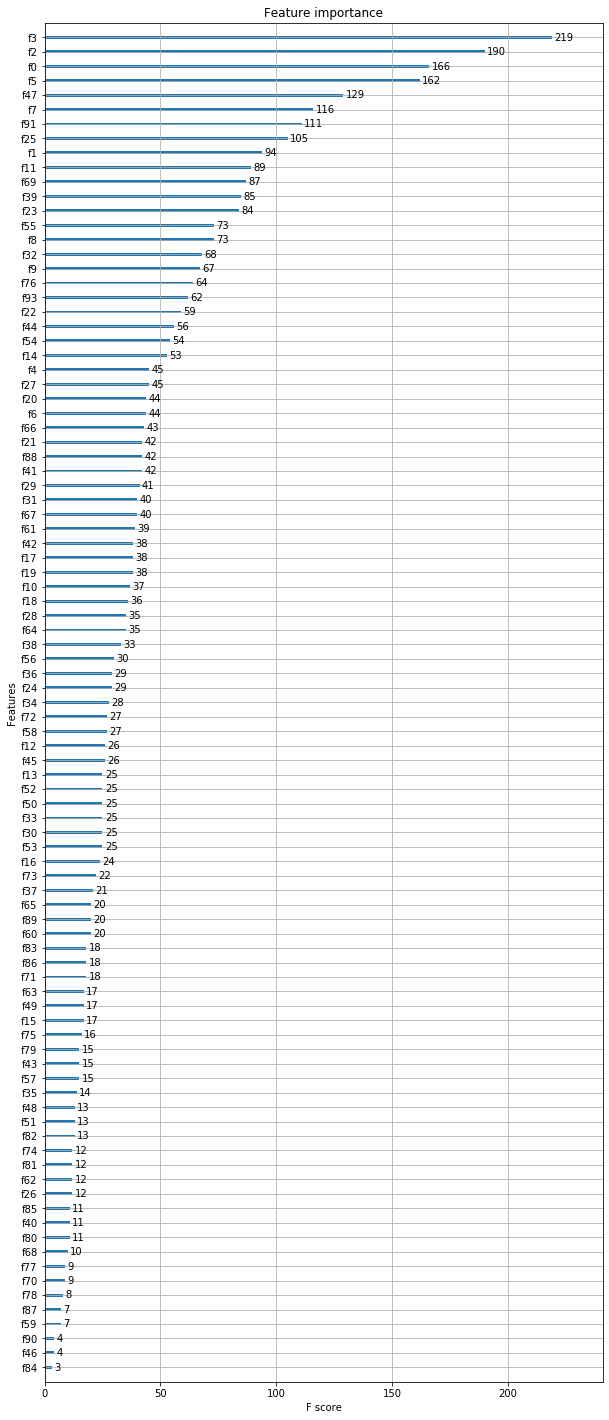

In [62]:
plot_features(bst, (10,25))

In [65]:
cols = list(training.columns)

del cols[cols.index('item_cnt_month')]
[cols[x] for x in [3, 2,0,5,47, 25,7,69,91,4,23]]

['item_category_id',
 'date_block_num',
 'shop_id',
 'item_cnt_day_per_item_lag_1',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_1',
 'price_std_per_item_lag_1',
 'item_cnt_month_lag_3',
 'item_cnt_month_lag_6',
 'item_price_per_item_lag_1',
 'cnt_day_shop_cat_lag_1']

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

In [67]:
category_feat = ['item_id','shop_id','item_category_id']

In [68]:
# X_train_lr = training.drop(category_feat + ['item_cnt_month'], axis=1)

# for feat in X_train_lr.columns:
#     X_train_lr[feat] = X_train_lr[feat].fillna(X_train_lr[feat].median())

In [69]:
# X_train_lr.date_block_num = X_train_lr.date_block_num.astype(str)
# X_train_lr.to_csv('lr_dataframe.csv',index=False)
# X_train_lr.date_block_num = pd.get_dummies(X_train_lr.date_block_num,sparse=False)      
# scaler = preprocessing.StandardScaler()

# X_train_lr = scaler.fit_transform(X_train_lr)

In [70]:
# lr = LinearRegression()

# lr.fit(X_train_lr, training['item_cnt_month'])

In [71]:
#ensembleのためにｃｓｖファイルに保存する
# training.to_csv('xgb_dataframe.csv',index=False)

In [72]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [73]:
test['date_block_num'] = 34
# test['month'] = test['date_block_num'] % 12
# test['days'] = 31

In [74]:
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


In [75]:
test = pd.merge(test, items, on=['item_id'], how='left')

In [76]:
lag_variables.append('item_cnt_month')
for lag in tqdm_notebook(lags):
    sales_new_df = mean_transactions.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num', 'shop_id','item_id'] + lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id'] + [lag_feat + '_lag_'  + str(lag) for lag_feat in lag_variables]
    test = pd.merge(test, sales_new_df, on=['date_block_num','shop_id','item_id'],how='left')

In [77]:
test = pd.merge(test, shops, on=['shop_id'], how='left')

In [78]:
test.head(10)

,ID,shop_id,item_id,date_block_num,item_name,item_category_id,item_price_per_item_lag_1,item_cnt_day_per_item_lag_1,sales_per_item_lag_1,price_std_per_item_lag_1,cnt_day_std_per_item_lag_1,sales_std_per_item_lag_1,product_sales_lag_1,item_cnt_day_per_shop_lag_1,item_price_per_shop_lag_1,sales_per_shop_lag_1,cnt_day_std_shop_lag_1,price_std_per_shop_lag_1,sales_std_per_shop_lag_1,item_cnt_day_per_category_lag_1,item_price_per_category_lag_1,sales_per_category_lag_1,cnt_day_std_per_category_lag_1,price_std_per_category_lag_1,sales_std_per_category_lag_1,cnt_day_shop_cat_lag_1,price_shop_cat_lag_1,item_cnt_month_lag_1,item_price_per_item_lag_2,item_cnt_day_per_item_lag_2,sales_per_item_lag_2,price_std_per_item_lag_2,cnt_day_std_per_item_lag_2,sales_std_per_item_lag_2,product_sales_lag_2,item_cnt_day_per_shop_lag_2,item_price_per_shop_lag_2,sales_per_shop_lag_2,cnt_day_std_shop_lag_2,price_std_per_shop_lag_2,sales_std_per_shop_lag_2,item_cnt_day_per_category_lag_2,item_price_per_category_lag_2,sales_per_category_lag_2,cnt_day_std_per_category_lag_2,price_std_per_category_lag_2,sales_std_per_category_lag_2,cnt_day_shop_cat_lag_2,price_shop_cat_lag_2,item_cnt_month_lag_2,item_price_per_item_lag_3,item_cnt_day_per_item_lag_3,sales_per_item_lag_3,price_std_per_item_lag_3,cnt_day_std_per_item_lag_3,sales_std_per_item_lag_3,product_sales_lag_3,item_cnt_day_per_shop_lag_3,item_price_per_shop_lag_3,sales_per_shop_lag_3,cnt_day_std_shop_lag_3,price_std_per_shop_lag_3,sales_std_per_shop_lag_3,item_cnt_day_per_category_lag_3,item_price_per_category_lag_3,sales_per_category_lag_3,cnt_day_std_per_category_lag_3,price_std_per_category_lag_3,sales_std_per_category_lag_3,cnt_day_shop_cat_lag_3,price_shop_cat_lag_3,item_cnt_month_lag_3,item_price_per_item_lag_6,item_cnt_day_per_item_lag_6,sales_per_item_lag_6,price_std_per_item_lag_6,cnt_day_std_per_item_lag_6,sales_std_per_item_lag_6,product_sales_lag_6,item_cnt_day_per_shop_lag_6,item_price_per_shop_lag_6,sales_per_shop_lag_6,cnt_day_std_shop_lag_6,price_std_per_shop_lag_6,sales_std_per_shop_lag_6,item_cnt_day_per_category_lag_6,item_price_per_category_lag_6,sales_per_category_lag_6,cnt_day_std_per_category_lag_6,price_std_per_category_lag_6,sales_std_per_category_lag_6,cnt_day_shop_cat_lag_6,price_shop_cat_lag_6,item_cnt_month_lag_6,shop_name,city_name,city_frequency
0,0,5,5037,34,"NHL 15 [PS3, русские субтитры]",19,1499.00000,1.000000,1499.000000,0.000000,0.000000,0.000000,0.0,1.090155,1030.721924,1140.12439,0.449938,1654.235107,2012.336304,1.041791,1681.477905,1785.249023,0.304898,835.197998,1260.846924,1.013514,1548.945923,0.0,941.385193,1.428571,1258.038940,327.270966,1.657746,1266.470825,749.5,1.148265,1034.784302,1231.808594,0.877853,1661.687866,2667.791748,1.273688,1358.810913,1863.874756,1.332492,846.124573,3326.656006,1.195652,1355.232666,1.0,894.589844,1.190000,1036.971558,290.747772,0.544857,457.709259,2997.5,1.080134,921.702942,969.072205,0.41916,1669.297607,1915.93335,1.126207,1140.894653,1239.744751,0.519704,653.849548,765.679199,1.062016,1169.719482,3.0,1542.868774,1.087500,1656.543701,510.550049,0.284349,583.962952,1299.0,1.143503,958.609863,1171.629395,0.902971,1724.408203,3209.707275,1.061991,1419.183105,1494.353638,0.407311,679.342346,877.990784,1.013699,1316.797974,1.0,"Вологда ТРЦ ""Мармелад""",Вологда,0.016667
1,1,5,5320,34,ONE DIRECTION Made In The A.M.,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Вологда ТРЦ ""Мармелад""",Вологда,0.016667
2,2,5,5233,34,"Need for Speed Rivals (Essentials) [PS3, русск...",19,1199.00000,1.024390,1228.243896,0.000000,0.156174,187.252335,1199.0,1.090155,1030.721924,1140.12439,0.449938,1654.235107,2012.336304,1.041791,1681.477905,1785.249

In [79]:
len(test.columns)

97

In [80]:
# encoder = test.groupby('item_id').size()
# encoder = encoder/len(test)

# test['item_freq'] = test['item_id'].map(encoder)

In [81]:
test = test.drop(['ID','item_name','shop_name'], axis=1)

In [82]:
test.city_name = le.fit_transform(test.city_name)

In [83]:
for feat in test.columns:
    if 'cnt' in feat:
        test[feat] = test[feat].fillna(0)
    elif 'price' in feat:
        test[feat] = test[feat].fillna(test[feat].median())

In [84]:
# test.to_csv('xgb_test.csv',index=False)

In [85]:
xgbpredict = xgb.DMatrix(test.values)

In [86]:
diff = list(set(training.columns) - set(test.columns))
diff

['item_cnt_month']

In [87]:
pred = bst.predict(xgbpredict)

In [88]:
# X_test_lr = test.drop(category_feat, axis=1)

# for feat in X_test_lr.columns:
#     X_test_lr[feat] = X_test_lr[feat].fillna(X_test_lr[feat].median())

# X_test_lr["date_block_num"] = X_test_lr.date_block_num.astype(str)
# X_test_lr.to_csv('lr_test.csv',index=False)
# X_test_lr["date_block_num"] = pd.get_dummies(X_test_lr.date_block_num,sparse=False)

In [89]:
# X_test_lr = scaler.fit_transform(X_test_lr)
# pred_lr = lr.predict(X_test_lr)
# pred_lr = pred_lr.clip(0,20)

In [90]:
pd.Series(pred).describe()

count    214200.000000
mean          0.301610
std           0.730858
min          -0.261643
25%           0.059145
50%           0.120063
75%           0.258673
max          19.164074
dtype: float64

In [91]:
# pd.Series(pred_lr).describe()

In [92]:
pred = pred.clip(0,20)

## 標準偏差を付け加えた時と線形回帰とxbgboostの結果。スコアは0.98と1.10

In [93]:
pd.Series(pred).describe()

count    214200.000000
mean          0.301870
std           0.730739
min           0.000000
25%           0.059145
50%           0.120063
75%           0.258673
max          19.164074
dtype: float64

In [94]:
sub_df = pd.DataFrame({'ID':test.index,'item_cnt_month':pred})

In [95]:
# sub_lr_df = pd.DataFrame({'ID':test.index,'item_cnt_month':pred_lr})

In [96]:
sub_df.head()

,ID,item_cnt_month
0,0,0.447323
1,1,0.150246
2,2,1.506700
3,3,0.302600
4,4,3.536647


In [99]:
sub_df.to_csv('early_stop_xgb.csv',index=False)

In [98]:
#sub_lr_df.to_csv('lr_std.csv',index=False)